In [1]:
import pandas as pd
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.utils import pad_sequences
import keras
from keras import layers
import numpy as np
from sklearn.model_selection import train_test_split

import draft.data_cleaning as dc

In [2]:
person_1 = pd.read_json(r'datasets/december/liza.json', orient='records', lines=True) # liza
person_2 = pd.read_json(r'datasets/december/sleep_data_Adham.json', lines=True) # adham
person_3 = pd.read_json(r'datasets/december/sleep_data_Miriam.json', lines=True) # miriam
person_4 = pd.read_json(r'datasets/december/sleep_data_Syahid.json', lines=True) # syahid
person_5 = pd.read_json(r'datasets/december/sleep_data_florian.json', lines=True)  #  florian

# labels dataframe from excel
labels_df = pd.read_excel(r'datasets\sleep_data.xlsx', sheet_name=None) # dict of all label

In [3]:
people_df = [person_1, person_2, person_3, person_4, person_5]

for num, df in enumerate(people_df):
    df.insert(0, "temp_id", num)

people_df

[    temp_id                                      dailySleepDTO  \
 0         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 1         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 2         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 3         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 4         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 5         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 6         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 7         0  {'id': None, 'userProfilePK': 116790140, 'cale...   
 8         0  {'id': 1701986940000, 'userProfilePK': 1167901...   
 9         0  {'id': 1702078860000, 'userProfilePK': 1167901...   
 10        0  {'id': 1702171920000, 'userProfilePK': 1167901...   
 11        0  {'id': 1702254240000, 'userProfilePK': 1167901...   
 12        0  {'id': 1702340700000, 'userProfilePK': 1167901...   
 13        0  {'id': 1702425900000, 'userProfilePK': 1167901..

In [4]:
time_series_list = []

for num, df in enumerate(people_df):
    # Extrahieren der Zeitreihendaten (Annahme: gibt einen DataFrame zurück)
    temp_df = dc.main_interpolation(df)

    # Weisen Sie die eindeutige ID dem DataFrame zu
    temp_df['temp_id'] = num

    # Fügen Sie den aktualisierten DataFrame der neuen Liste hinzu
    time_series_list.append(temp_df)

len(time_series_list)

5

In [5]:
time_series_list[0][1].shape

(542, 7)

In [6]:
# find total nights
total_nights = 0
# Durchlaufen jeder Person in der Liste
for person_index, person_data in enumerate(time_series_list):
    print(f"Person {person_index + 1}:")

    # Überprüfen, ob person_data ein Dictionary ist
    if isinstance(person_data, dict):
        # Durchlaufen jedes Nacht-DataFrames der Person
        for night, df in person_data.items():
            # Überprüfen, ob der Wert ein DataFrame ist
            if isinstance(df, pd.DataFrame):
                #if len(df) > max_length:
                    #max_length = len(df)
                    print(f"  Nacht {night}: {len(df)} Zeilen")
                    total_nights +=1

print(total_nights)

Person 1:
  Nacht 0: 626 Zeilen
  Nacht 1: 542 Zeilen
  Nacht 2: 428 Zeilen
  Nacht 3: 359 Zeilen
  Nacht 4: 520 Zeilen
  Nacht 5: 413 Zeilen
  Nacht 6: 548 Zeilen
  Nacht 7: 667 Zeilen
  Nacht 8: 428 Zeilen
  Nacht 9: 522 Zeilen
  Nacht 10: 396 Zeilen
  Nacht 11: 541 Zeilen
  Nacht 12: 437 Zeilen
  Nacht 13: 415 Zeilen
  Nacht 14: 552 Zeilen
Person 2:
  Nacht 0: 476 Zeilen
  Nacht 1: 355 Zeilen
  Nacht 2: 344 Zeilen
  Nacht 3: 454 Zeilen
  Nacht 4: 313 Zeilen
  Nacht 5: 529 Zeilen
  Nacht 6: 254 Zeilen
  Nacht 7: 320 Zeilen
  Nacht 8: 600 Zeilen
  Nacht 9: 301 Zeilen
  Nacht 10: 584 Zeilen
  Nacht 11: 384 Zeilen
  Nacht 12: 478 Zeilen
  Nacht 13: 478 Zeilen
  Nacht 14: 434 Zeilen
  Nacht 15: 324 Zeilen
  Nacht 16: 562 Zeilen
  Nacht 17: 505 Zeilen
  Nacht 18: 394 Zeilen
Person 3:
  Nacht 0: 579 Zeilen
  Nacht 1: 313 Zeilen
  Nacht 2: 495 Zeilen
  Nacht 3: 455 Zeilen
  Nacht 4: 547 Zeilen
  Nacht 5: 481 Zeilen
  Nacht 6: 458 Zeilen
  Nacht 7: 524 Zeilen
  Nacht 8: 314 Zeilen
  Nacht 9:

In [7]:
def calculate_maximum_length(list_):
    max_length = 0  # Initialize max_length to store the maximum number of rows

    # Iterate through each person in the list
    for person_index, person_data in enumerate(time_series_list):
        # Iterate through each night DataFrame of the person
        for night, df in person_data.items():
            # Check if the value is a DataFrame
            if isinstance(df, pd.DataFrame):
                # Update max_length if this night has more rows
                if len(df) > max_length:
                    max_length = len(df)

    # After completing the iteration, max_length will hold the number of rows of the longest night
    return max_length

max_length = calculate_maximum_length(time_series_list)
max_length

994

In [8]:
"""This step is necessary because we are using convolutional layers that halve the dimensions after every layer. 
If any halve produces a .5, the ceiling will be taken. This causes the Upsampling to reproduce different dimensions that our original input. """

# Determine how many layers are in our Conv1D network. (how many times the data will be halved)
n_layers = 4

while True:
    if max_length % n_layers != 0:
        max_length += 1
    else:
        break

max_length

996

In [9]:
# List to store normalized and padded dataframes
normalized_padded_dfs = []

for person_data in time_series_list:
    for night,df in person_data.items():
        if isinstance(df, pd.DataFrame):
            # Pad them to ensure  they have the same length (needed for training/testing split)
            df_padded = pad_sequences([df.values],maxlen=max_length,dtype='float32', padding='post')
            # Add the padded dataframe to the list of normalized & padded dataframes
            normalized_padded_dfs.append((df_padded[0]))

normalized_padded_dfs[0].shape

(996, 7)

In [10]:
normalized_padded_dfs

[array([[0.33333334, 0.6363636 , 0.        , ..., 0.17073171, 0.04301075,
         0.22222222],
        [0.33333334, 0.6818182 , 0.        , ..., 0.1910569 , 0.04301075,
         0.2       ],
        [0.33333334, 0.6818182 , 0.        , ..., 0.21138212, 0.04301075,
         0.21111111],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 array([[0.33333334, 0.77272725, 0.        , ..., 0.36585367, 0.05376344,
         0.5       ],
        [0.33333334, 0.77272725, 0.        , ..., 0.34146342, 0.05376344,
         0.51111114],
        [0.33333334, 0.77272725, 0.        , ..., 0.34552845, 0.05376344,
         0.5       ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        

In [11]:
# Convert the list to an array
data = np.array(normalized_padded_dfs)

# Split into training and test
X_train, X_test = train_test_split(data, test_size=0.2,random_state=42)

# Define input dimensions
n_features = 7

X_train.shape

(72, 996, 7)

In [12]:
# Create model
model = keras.Sequential(
    [
        layers.Input(shape=(max_length,n_features)),
        layers.Conv1D(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=64,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=n_features, kernel_size=7, padding="same"),
    ]
)

# Define function to save embeddings
def save_embeddings(model, x_data, save_path='embeddings.npy'):
    embeddings = model.predict(x_data)
    np.save(save_path, embeddings)
    print(f'Embeddings saved to {save_path}')

 # Compile model and visualize layers
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# Print model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 64)           3200      
                                                                 
 dropout (Dropout)           (None, 498, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 249, 32)           14368     
                                                                 
 conv1d_transpose (Conv1DTr  (None, 498, 32)           7200      
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 498, 32)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 996, 64)           14400     
 Transpose)                                             

In [14]:
# Define checkpoints and early stopping
checkpoint = keras.callbacks.ModelCheckpoint('autoencoder_Conv1D.h5', save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the autoencoder
history = model.fit(
    X_train,
    X_train,
    epochs=150,
    batch_size=32,
    validation_split=0.15,
    callbacks=[
        checkpoint,
        early_stopping
    ],
)

Epoch 1/150
2/2 [==============================] - 0s 209ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 2/150
2/2 [==============================] - 0s 115ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 3/150
2/2 [==============================] - 0s 108ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 4/150
2/2 [==============================] - 0s 140ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 5/150
2/2 [==============================] - 0s 110ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 6/150
2/2 [==============================] - 0s 151ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/150
2/2 [==============================] - 0s 110ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 8/150
2/2 [==============================] - 0s 136ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/150
2/2 [==============================] - 0s 110ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/150
2/2 [==============================] - 0s 137ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 11/

Autoencoder visualization

1/1 [==============================] - 0s 197ms/step


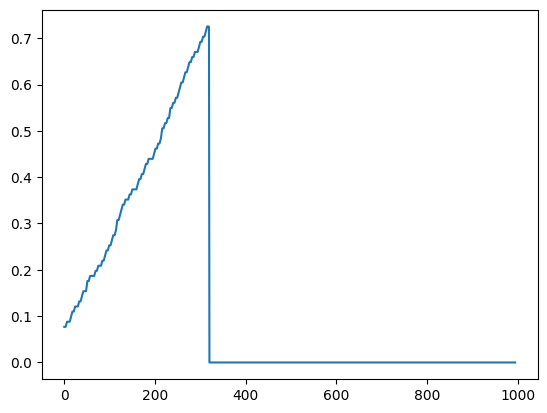

In [15]:
from matplotlib import pyplot as plt

X_test_recon = model.predict(X_test)

# 1st day in X_test, all values for the last feature
plt.plot(X_test[1,:-1,5])
plt.show()

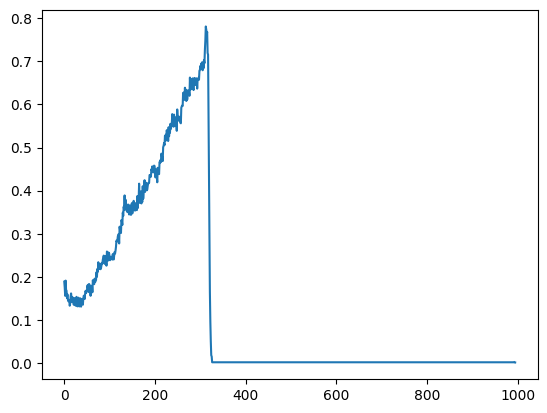

In [16]:
# 1st day in X_test_recon, all values for the second last feature
plt.plot(X_test_recon[1,:-1,5])
plt.show()

1/1 [==============================] - 0s 74ms/step
Embeddings saved to X_test_embeddings.npy


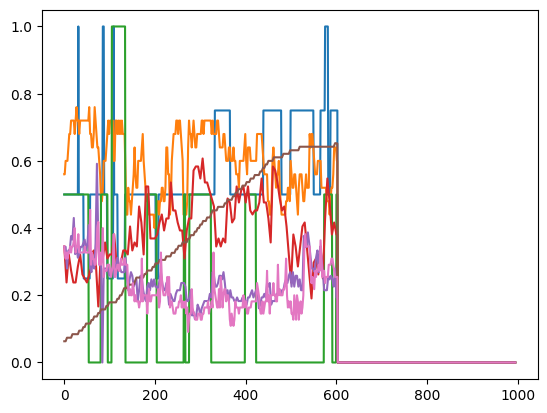

In [17]:
encoder_model = keras.models.Model(inputs= model.input, outputs=model.get_layer(index=2).output)
save_embeddings(encoder_model,X_test,save_path="X_test_embeddings.npy")
X_test_embeddings = np.load("X_test_embeddings.npy")
plt.plot(X_test[2][:-1])
plt.show()

In [18]:
X_test.shape

(19, 996, 7)

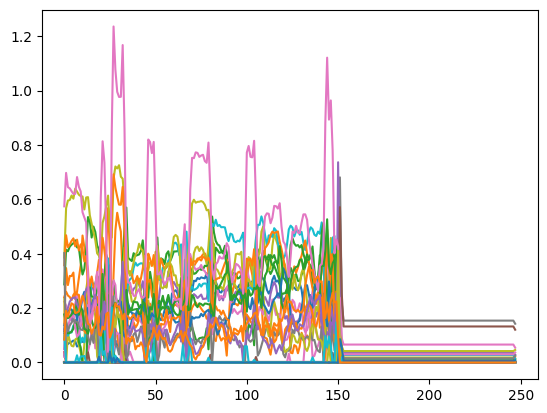

In [19]:
plt.plot(X_test_embeddings[2][:-1])
plt.show()

In [20]:
X_test_embeddings.shape

(19, 249, 32)